In [1]:
import mxnet as mx
from mxnet import init, gluon, nd, autograd, image
from mxnet.gluon import nn
from mxnet.contrib.ndarray import MultiBoxPrior, MultiBoxTarget, MultiBoxDetection
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from time import time
%matplotlib inline
mpl.rcParams['figure.dpi']= 120
ctx = mx.gpu()
data_dir = '/home/sinyer/python/data/pikachu'

In [2]:
def load_data(batch_size, data_route = data_dir):
    root_url = ('https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/')
    data_dir = data_route+'/'
    dataset = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
              'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
              'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}
    for k, v in dataset.items():
        gluon.utils.download(root_url+k, data_dir+k, sha1_hash=v)
    
    train_iter = image.ImageDetIter(
        batch_size = batch_size, data_shape = (3, 256, 256),
        path_imgrec = data_dir+'train.rec', path_imgidx = data_dir+'train.idx',
        shuffle = True, mean = True, rand_crop = 1,
        min_object_covered = 0.95, max_attempts = 200)
    val_iter = image.ImageDetIter(
        batch_size = batch_size, data_shape = (3, 256, 256),
        path_imgrec=data_dir+'val.rec', shuffle=False, mean=True)
    return train_iter, val_iter

In [3]:
batch_size = 32
class_names = ['pikachu', 'dummy']
num_class = len(class_names)

train_data, test_data = load_data(batch_size)
train_data.reshape(label_shape=(3, 5))
train_data = test_data.sync_label_shape(train_data)

In [4]:
def class_predictor(num_anchors, num_classes):
    return nn.Conv2D(num_anchors * (num_classes + 1), 3, padding=1)

def box_predictor(num_anchors):
    return nn.Conv2D(num_anchors * 4, 3, padding=1)

def down_sample(num_filters):
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filters, 3, strides=1, padding=1))
        out.add(nn.BatchNorm(in_channels=num_filters))
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2))
    return out

def flatten_prediction(pred):
    return pred.transpose(axes=(0,2,3,1)).flatten()

def concat_predictions(preds):
    return nd.concat(*preds, dim=1)

def body():
    out = nn.HybridSequential()
    for nfilters in [16, 32, 64]:
        out.add(down_sample(nfilters))
    return out

def toy_ssd_model(num_anchors, num_classes):
    downsamplers = nn.Sequential()
    for _ in range(3):
        downsamplers.add(down_sample(128))
    class_predictors = nn.Sequential()
    box_predictors = nn.Sequential()    
    for _ in range(5):
        class_predictors.add(class_predictor(num_anchors, num_classes))
        box_predictors.add(box_predictor(num_anchors))
    model = nn.Sequential()
    model.add(body(), downsamplers, class_predictors, box_predictors)
    return model

def toy_ssd_forward(x, model, sizes, ratios):    
    body, downsamplers, class_predictors, box_predictors = model
    anchors, class_preds, box_preds = [], [], []
    x = body(x)
    for i in range(5):
        anchors.append(MultiBoxPrior(x, sizes=sizes[i], ratios=ratios[i]))
        class_preds.append(flatten_prediction(class_predictors[i](x)))
        box_preds.append(flatten_prediction(box_predictors[i](x)))
        if i < 3:
            x = downsamplers[i](x)
        elif i == 3:
            x = nd.Pooling(x, global_pool=True, pool_type='max', 
                           kernel=(x.shape[2], x.shape[3]))
    return (concat_predictions(anchors), 
            concat_predictions(class_preds), 
            concat_predictions(box_preds))

def training_targets(anchors, class_preds, labels):
    class_preds = class_preds.transpose(axes=(0,2,1))
    return MultiBoxTarget(anchors, labels, class_preds)

In [5]:
class ToySSD(gluon.Block):
    def __init__(self, num_classes, **kwargs):
        super(ToySSD, self).__init__(**kwargs)
        self.sizes = [[.2,.272], [.37,.447], [.54,.619], [.71,.79], [.88,.961]]
        self.ratios = [[1,2,.5]]*5
        self.num_classes = num_classes
        num_anchors = len(self.sizes[0]) + len(self.ratios[0]) - 1
        with self.name_scope():
            self.model = toy_ssd_model(num_anchors, num_classes)
    def forward(self, x):
        anchors, class_preds, box_preds = toy_ssd_forward(
            x, self.model, self.sizes, self.ratios)  
        class_preds = class_preds.reshape(shape=(0, -1, self.num_classes+1))
        return anchors, class_preds, box_preds

class FocalLoss(gluon.loss.Loss):
    def __init__(self, axis=-1, alpha=0.25, gamma=2, batch_axis=0, **kwargs):
        super(FocalLoss, self).__init__(None, batch_axis, **kwargs)
        self._axis = axis
        self._alpha = alpha
        self._gamma = gamma
    def hybrid_forward(self, F, output, label):
        output = F.softmax(output)
        pj = output.pick(label, axis=self._axis, keepdims=True)
        loss = - self._alpha * ((1 - pj) ** self._gamma) * pj.log()
        return loss.mean(axis=self._batch_axis, exclude=True)
    
class SmoothL1Loss(gluon.loss.Loss):
    def __init__(self, batch_axis=0, **kwargs):
        super(SmoothL1Loss, self).__init__(None, batch_axis, **kwargs)
    def hybrid_forward(self, F, output, label, mask):
        loss = F.smooth_l1((output - label) * mask, scalar=1.0)
        return loss.mean(self._batch_axis, exclude=True)

In [6]:
cls_loss = FocalLoss()
box_loss = SmoothL1Loss()

net = ToySSD(num_class)
net.initialize(init.Xavier(magnitude=2), ctx=ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1, 'wd': 5e-4})

In [7]:
for epoch in range(30):
    start = time()
    train_data.reset()
    for i, batch in enumerate(train_data):
        x = batch.data[0].as_in_context(ctx)
        y = batch.label[0].as_in_context(ctx)
        with autograd.record():
            anchors, class_preds, box_preds = net(x)
            box_target, box_mask, cls_target = training_targets(anchors, class_preds, y)
            loss1 = cls_loss(class_preds, cls_target)
            loss2 = box_loss(box_preds, box_target, box_mask)
            loss = loss1 + loss2
        loss.backward()
        trainer.step(batch_size)
    if epoch%1 == 0:
        print('%d, loss %.4f, t %.4f' % (epoch, nd.mean(loss).asscalar(), time()-start))

0, loss 0.0177, t 8.6969
1, loss 0.0118, t 6.3745
2, loss 0.0107, t 6.7067
3, loss 0.0101, t 6.2494
4, loss 0.0078, t 6.2951
5, loss 0.0073, t 6.3117
6, loss 0.0075, t 6.3495
7, loss 0.0066, t 6.2422
8, loss 0.0069, t 6.2557
9, loss 0.0054, t 6.2858
10, loss 0.0055, t 6.2945
11, loss 0.0052, t 6.3155
12, loss 0.0052, t 6.2701
13, loss 0.0048, t 6.2935
14, loss 0.0044, t 6.2732
15, loss 0.0042, t 6.3306
16, loss 0.0045, t 6.2998
17, loss 0.0041, t 6.3379
18, loss 0.0040, t 6.2879
19, loss 0.0057, t 6.2557
20, loss 0.0038, t 6.3175
21, loss 0.0038, t 6.2653
22, loss 0.0046, t 6.2975
23, loss 0.0044, t 6.3520
24, loss 0.0042, t 6.3154
25, loss 0.0033, t 6.2273
26, loss 0.0034, t 6.3524
27, loss 0.0039, t 6.2640
28, loss 0.0034, t 6.6087
29, loss 0.0034, t 6.3442


In [13]:
def process_image(fname):
    rgb_mean = nd.array([123, 117, 104])
    with open(fname, 'rb') as f:
        im = image.imdecode(f.read())
    data = image.imresize(im, 256, 256)
    data = data.astype('float32') - rgb_mean
    return data.transpose((2,0,1)).expand_dims(axis=0), im

def predict(x):
    anchors, cls_preds, box_preds = net(x.as_in_context(ctx))
    cls_probs = nd.SoftmaxActivation(cls_preds.transpose((0,2,1)), mode='channel')
    return MultiBoxDetection(cls_probs, box_preds, anchors,force_suppress=True, clip=False)

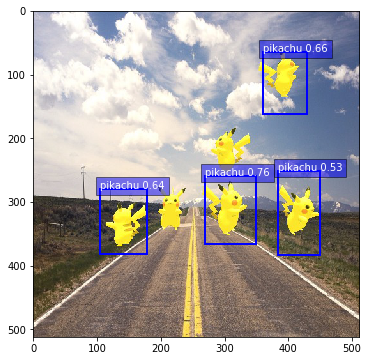

In [14]:
x, im = process_image('pikachu.jpg')
out = predict(x)

mpl.rcParams['figure.figsize'] = (6,6)

colors = ['blue', 'green', 'red', 'black', 'magenta']

def box_to_rect(box, color, linewidth=3):
    box = box.asnumpy()
    return plt.Rectangle(
        (box[0], box[1]), box[2]-box[0], box[3]-box[1],
        fill=False, edgecolor=color, linewidth=linewidth)

def display(im, out, threshold=0.5):    
    plt.imshow(im.asnumpy())
    for row in out:
        row = row.asnumpy()
        class_id, score = int(row[0]), row[1]
        if class_id < 0 or score < threshold:
            continue
        color = colors[class_id%len(colors)]
        box = row[2:6] * np.array([im.shape[0],im.shape[1]]*2)
        rect = box_to_rect(nd.array(box), color, 2)
        plt.gca().add_patch(rect)
        text = class_names[class_id]
        plt.gca().text(box[0], box[1], '{:s} {:.2f}'.format(text, score),
                       bbox=dict(facecolor=color, alpha=0.5), fontsize=10, color='white')
    plt.show()

display(im, out[0], threshold=0.5)